In [1]:
import os
import glob
import numpy as np
import bokeh.io
import bokeh.plotting
import bokeh.palettes
from bokeh.transform import jitter
import seaborn as sns
import matplotlib
from bokeh.models import HoverTool, Range1d
from scipy import stats
import pandas as pd
import math

from bokeh.layouts import row
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
def bootstrap_sampling(my_array, bootstrap_samples, bootstrap_replicates):
    bs_samples=np.zeros((bootstrap_replicates, bootstrap_samples))
    bs_rep=np.arange(bootstrap_replicates)
    for i in bs_rep:
        bs_samples[i, :]=np.random.choice(my_array, bootstrap_samples)
    return bs_samples

def bootstrap_stats(bs_samples):
    samples_shape=np.shape(bs_samples)
    bs_means=np.zeros((samples_shape[0], 1))
    bs_IC_means=np.zeros((1, 2))
    bs_medians=np.zeros((samples_shape[0], 1))
    bs_IC_medians=np.zeros((1, 2))
    for i in np.arange(samples_shape[0]):
        bs_means[i]=np.mean(bs_samples[i, :])
        bs_medians[i]=np.median(bs_samples[i, :])
    bs_IC_means[0, 0]=np.quantile(bs_means, .025)
    bs_IC_means[0, 1]=np.quantile(bs_means, .975)
    bs_IC_medians[0, 0]=np.quantile(bs_medians, .025)
    bs_IC_medians[0, 1]=np.quantile(bs_medians, .975)
    return np.mean(bs_means), np.median(bs_medians), bs_IC_means, bs_IC_medians

In [3]:
#set root folder
#path='D:/Pili_and_PaQa_counts_data/fliC-'
path='D:/Lorenzo/pilH'
#path='G:/Sauvegardes PhD/Covid-19/Pili_and_PaQa_counts_data/PaQa_data/fliC-'
os.chdir(path)
extension = 'csv'
list_csv = []
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        if extension in name:
            list_csv.append(os.path.join(root, name))
#os.chdir("C:/users/tala/git/PhD_codes/Mechanosensation/Python_code/Pole_analysis/")
os.chdir("C:/users/tala/Desktop/git/PhD_codes/Mechanosensation/Python_code/Pole_analysis/")
new_dir = "Data_PaQa_pilH-\\"
if not os.path.exists(new_dir):
    os.mkdir(new_dir)
os.chdir(new_dir)
combined_csv = pd.concat([pd.read_csv(f) for f in list_csv ], sort=False)
combined_csv.to_csv( "Pili_PaQa_Data_pilH-.csv", index=False, encoding='utf-8-sig')
combined_csv.head()

,,Label,Area,Mean,Min,Max,X,Y,BiologicalReplicate,CellArea,...,Y_PoleBright,AreaPoleBright,MeanPoleBright,TotalFluorescencePoleBright,MinPoleBright,MaxPoleBright,StdPoleBright,Nb_Pili_PoleBright,Nb_Flagella_PoleBright,PolarRatio
0,1.0,pilH-fliC-_PaQa_solid_0_event2_tirf_RAW_Stack.tif,2560.0,255.0,255.0,255.0,87.25195,33.47227,1.0,2740.0,...,217.66919,316.0,3004.09810,949295.0,1005.0,3759.0,882.35101,10,0.0,0.90771
0,1.0,pilH-fliC-_PaQa_solid_0_event4_tirf_RAW_Stack.tif,1327.0,255.0,255.0,255.0,58.88809,34.11191,1.0,1445.0,...,193.43802,256.0,2905.67969,743854.0,1273.0,3783.0,913.50452,5,0.0,0.83834
0,1.0,pilH-fliC-_PaQa_solid_1_event5_tirf_RAW_Stack.tif,1438.0,255.0,255.0,255.0,71.40473,24.42211,1.0,1565.0,...,225.94845,208.0,3105.83654,646014.0,888.0,3793.0,949.93060,8,0.0,0.89949
0,NaN,PilH-FliC-_1.2msExp_Flow0.3ul_Fast_1_event1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN
1,NaN,PilH-FliC-_1.5msExp_Flow0.3ul_0_event2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN


In [4]:
app_root_dir = "C:/Users/tala/Desktop/git/PhD_codes/Mechanosensation/Python_code/Pole_analysis/"
os.chdir(app_root_dir + "Data_PaQa_pilH-\\")
df_full = pd.read_csv("Pili_PaQa_Data_pilH-.csv", sep=',', na_values='*')
df_full['PercentTotalFluoDim']=df_full['TotalFluorescencePoleDim']/df_full['CellTotalFluorescence']
df_full['PercentTotalFluoBright']=df_full['TotalFluorescencePoleBright']/df_full['CellTotalFluorescence']
df_full['TotalPili']=df_full['Nb_Pili_PoleDim']+df_full['Nb_Pili_PoleBright']
df_full['TotalFlagella']=df_full['Nb_Flagella_PoleDim']+df_full['Nb_Flagella_PoleBright']
param1='CellTotalFluorescence'
param2='TotalPili'
poisson_lambda=df_full[param2].mean()

tot_pili_limit=50
df=df_full.loc[df_full[param2]<tot_pili_limit]        

Ncells_per_pili=np.empty((tot_pili_limit), dtype='int16')
N=len(df)
print('Ncells='+str(N), end=', ')
for i in range(tot_pili_limit):
    Ncells_per_pili[i]=len(df.loc[(df[param2]==i)])
    if (i<tot_pili_limit-1):
        print('N_'+str(i)+'pili='+str(Ncells_per_pili[i]), end=', ')
    else: print('N_'+str(i)+'pili='+str(Ncells_per_pili[i]))       
df.head()

Ncells=9, N_0pili=0, N_1pili=0, N_2pili=0, N_3pili=0, N_4pili=0, N_5pili=0, N_6pili=0, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0, N_11pili=0, N_12pili=0, N_13pili=1, N_14pili=1, N_15pili=1, N_16pili=1, N_17pili=1, N_18pili=0, N_19pili=0, N_20pili=2, N_21pili=0, N_22pili=1, N_23pili=1, N_24pili=0, N_25pili=0, N_26pili=0, N_27pili=0, N_28pili=0, N_29pili=0, N_30pili=0, N_31pili=0, N_32pili=0, N_33pili=0, N_34pili=0, N_35pili=0, N_36pili=0, N_37pili=0, N_38pili=0, N_39pili=0, N_40pili=0, N_41pili=0, N_42pili=0, N_43pili=0, N_44pili=0, N_45pili=0, N_46pili=0, N_47pili=0, N_48pili=0, N_49pili=0


,,Label,Area,Mean,Min,Max,X,Y,BiologicalReplicate,CellArea,...,MinPoleBright,MaxPoleBright,StdPoleBright,Nb_Pili_PoleBright,Nb_Flagella_PoleBright,PolarRatio,PercentTotalFluoDim,PercentTotalFluoBright,TotalPili,TotalFlagella
0,1.0,pilH-fliC-_PaQa_solid_0_event2_tirf_RAW_Stack.tif,2560.0,255.0,255.0,255.0,87.25195,33.47227,1.0,2740.0,...,1005.0,3759.0,882.35101,10,0.0,0.90771,0.105991,0.107932,20,0.0
1,1.0,pilH-fliC-_PaQa_solid_0_event4_tirf_RAW_Stack.tif,1327.0,255.0,255.0,255.0,58.88809,34.11191,1.0,1445.0,...,1273.0,3783.0,913.50452,5,0.0,0.83834,0.152775,0.162320,14,0.0
2,1.0,pilH-fliC-_PaQa_solid_1_event5_tirf_RAW_Stack.tif,1438.0,255.0,255.0,255.0,71.40473,24.42211,1.0,1565.0,...,888.0,3793.0,949.93060,8,0.0,0.89949,0.120131,0.125529,17,0.0
3,NaN,PilH-FliC-_1.2msExp_Flow0.3ul_Fast_1_event1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,13,NaN
4,NaN,PilH-FliC-_1.5msExp_Flow0.3ul_0_event2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,22,NaN


In [5]:
nb_pili=np.zeros((tot_pili_limit, 1))
boot_mean=np.zeros((tot_pili_limit, 1))
boot_median=np.zeros((tot_pili_limit, 1))
boot_IC_mean=np.zeros((tot_pili_limit, 2))
boot_IC_median=np.zeros((tot_pili_limit, 2))
for n_pili in range(tot_pili_limit):
    cell_fluorescence_array=df.CellTotalFluorescence.loc[(df[param2]==n_pili)].values
    nb_pili[n_pili]=n_pili
    if (len(cell_fluorescence_array) > 0):
        bs_cell_fluorescence_array=bootstrap_sampling(cell_fluorescence_array, len(cell_fluorescence_array), 1000)
        [bs_means, bs_medians, IC_means, IC_medians]=bootstrap_stats(bs_cell_fluorescence_array)
        boot_mean[n_pili]=bs_means
        boot_IC_mean[n_pili,:]=IC_means
        boot_median[n_pili]=bs_medians
        boot_IC_median[n_pili,:]=IC_medians

names = [param2, 'bootMean','bootMedian']
data = np.concatenate((nb_pili, boot_mean, boot_median), axis=1)
df_boot_stats=pd.DataFrame(data=np.transpose(data), index=names).T
df_boot_stats['IC_mean']=list(boot_IC_mean)
df_boot_stats['IC_median']=list(boot_IC_median)
df_boot_stats.to_csv( "boot_Pili_PaQa_Data.csv", index=False, encoding='utf-8-sig')
df_boot_stats.head(100)

C:\Users\tala\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\tala\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,TotalPili,bootMean,bootMedian,IC_mean,IC_median
0,0.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
1,1.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
2,2.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
3,3.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
4,4.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
5,5.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
6,6.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
7,7.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
8,8.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
9,9.0,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"


In [6]:
Prob_per_pili = Ncells_per_pili/N
Prob_per_pili.sum()

0.9999999999999999

In [7]:
p0 = bokeh.plotting.figure(
    width=600, 
    height=600, 
    x_axis_label='# pili', 
    y_axis_type='linear',
    y_axis_label ='P(# pili)',
    title="Probability of having # pili"
)

x_1=range(tot_pili_limit)

p0.line(
    x=x_1,
    y=Prob_per_pili, 
    line_color = 'blue',
    #fill_color = 'blue',
    alpha=0.7,
    #legend = labelsAll[i]
    legend = 'Data'
)

bokeh.io.show(p0)

In [8]:
print(param1+' vs '+param2+':')

[spearman_r, spearman_p]=stats.spearmanr(df[param1], df[param2])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df[param1], df[param2])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

CellTotalFluorescence vs TotalPili:
Spearman correlation = nan, p-value = nan


ValueError: array must not contain infs or NaNs

In [9]:
parameter1='bootMean'
parameter2='bootMedian'
IC1='IC_mean'
IC2='IC_median'
p3 = bokeh.plotting.figure(
    width=600, 
    height=600,  
    x_axis_type='linear',
    y_axis_type='linear',
    x_axis_label = '#Pili',
    y_axis_label = 'total fluorescence',
    title="Mean cell total fluorescence per pili nb (bootstrap mean, 95% IC)",
    x_range=Range1d(-0.5, tot_pili_limit)
)

p4 = bokeh.plotting.figure(
    width=600, 
    height=600,  
    x_axis_type='linear',
    y_axis_type='linear',
    x_axis_label = '#Pili',
    y_axis_label = 'total fluorescence',
    title="Median cell total fluorescence per pili nb (bootstrap median, 95% IC)",
    x_range=Range1d(-0.5, tot_pili_limit)
)

In [10]:
p3.circle(
    source=df,
    x=param2,
    y=param1, 
    line_color = 'blue',
    fill_color = 'navy',
    alpha=0.7,
    #legend = labelsAll[i]
)

p4.circle(
    source=df,
    x=param2,
    y=param1, 
    line_color = 'blue',
    fill_color = 'navy',
    alpha=0.7,
    #legend = labelsAll[i]
)

for n_pili in list(df_boot_stats[param2]):
    b = [n_pili,n_pili]
    m=df_boot_stats.loc[(df_boot_stats[param2] == n_pili), [parameter1]].values[0][0]
    ic=df_boot_stats.loc[(df_boot_stats[param2] == n_pili), [IC1]].values[0][0]
    if (m-ic[0] < 0):
        a = [0, m+ic[1]]
    else: a = [m-ic[0], m+ic[1]]
    p3.line(
        x = b,
        y = ic,
        color = 'black',
        alpha=0.5,
        line_width=3
    )
    
for n_pili in list(df_boot_stats[param2]):
    b = [n_pili,n_pili]
    m=df_boot_stats.loc[(df_boot_stats[param2] == n_pili), [parameter2]].values[0][0]
    ic=df_boot_stats.loc[(df_boot_stats[param2] == n_pili), [IC2]].values[0][0]
    if (m-ic[0] < 0):
        a = [0, m+ic[1]]
    else: a = [m-ic[0], m+ic[1]]
    p4.line(
        x = b,
        y = ic,
        color = 'black',
        alpha=0.5,
        line_width=3
    )
    
p3.circle(
    source = df_boot_stats.loc[:, [param2, parameter1]],
    x = param2,
    y = parameter1,
    line_color = 'black',
    fill_color = 'white',
    alpha=0.6,
    size=10
)

p4.circle(
    source = df_boot_stats.loc[:, [param2, parameter2]],
    x = param2,
    y = parameter2,
    line_color = 'black',
    fill_color = 'white',
    alpha=0.6,
    size=10
)  

p3.output_backend = 'svg'
p4.output_backend = 'svg'

bokeh.io.show(bokeh.layouts.row(p3, p4))

In [11]:
print(parameter2+' vs '+param2+':')

[spearman_r, spearman_p]=stats.spearmanr(df_boot_stats[parameter2], df_boot_stats[param2])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_boot_stats[parameter2], df_boot_stats[param2])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

bootMedian vs TotalPili:
Spearman correlation = nan, p-value = nan


ValueError: array must not contain infs or NaNs

In [12]:
df['piliB_piliD']=df['Nb_Pili_PoleBright']-df['Nb_Pili_PoleDim']
df['piliB_piliD_over_Tot']=df['piliB_piliD']/df['TotalPili']

2.4444444444444446
3.0


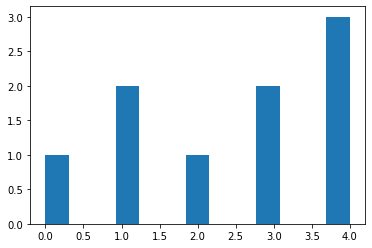

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

x_pili = np.abs(df.loc[df['TotalPili']>0,'piliB_piliD'].values)
print(np.mean(x_pili))
print(np.median(x_pili))
plt.hist(x_pili, bins = 13)
plt.show()
plt.savefig('piliDiff_pilH')

0.13985709516400052
0.13043478260869565


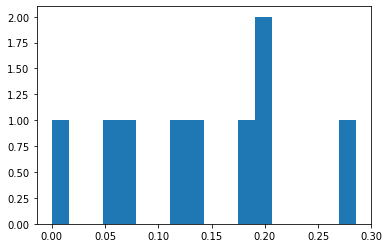

<Figure size 432x288 with 0 Axes>

In [14]:
y_pili = np.abs(df.loc[df['TotalPili']>0,'piliB_piliD_over_Tot'].values)
print(np.mean(y_pili))
print(np.median(y_pili))
plt.hist(y_pili, bins = 18)
plt.show()
plt.savefig('piliDiffoverTot_pilH-.png')